In [3]:
from dask.distributed import Client

client = Client(n_workers=6)

In [114]:
client

Client Scheduler: tcp://127.0.0.1:64906 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 12 Memory: 17.18 GB


In [178]:
import tiles_pb2
import datetime

In [186]:
import dask.dataframe as dd
import pandas as pd
import math

In [187]:
# Read parquet files in as set of dataframes
df = dd.read_parquet("s3://airflow-test-data/e0a14dbf-e8e6-42bd-b908-e72a956fadd5/749916f0-be24-4e4b-9a6c-798808a5be3c/*.parquet",
    storage_options={
        "anon": False,
        "use_ssl": False,
        "key":"foobar",
        "secret":"foobarbaz",
        "client_kwargs":{
            "region_name":"us-east-1",
            "endpoint_url":"http://10.64.18.141:9000"
        }
    })
# Read parquet files in as set of dataframes
#df = dd.read_parquet("data/3fd5794e-f7d3-4fcf-922b-652c93853caa/2f3e4c71-e296-4944-aba6-8d4eb063a23e/*.parquet")

In [188]:
df = df.astype({'value': 'float64'})
df.dtypes
# Just simply partition the file based on the size to run operations in distrubed manner (this might not be ideal way to partition data and this is just an experiment)
#df = df.repartition(partition_size="5MB")

timestamp     object
lat          float64
lng          float64
feature       object
value        float64
dtype: object

In [189]:
# More details on tile calculations https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames

# Convert lat, long to tile coord
# https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python
def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
  return (zoom, xtile, ytile)

# Get the parent tile coord of the given tile coord
def parent_tile(coord):
    z, x, y = coord
    return (z - 1, math.floor(x / 2), math.floor(y / 2))

# Return all acestor tile coords of the given tile coord
def ancestor_tiles(coord):
    tiles = [coord]
    while tiles[0][0] > 0:
        tiles.insert(0, parent_tile(tiles[0]))
    return tiles
        

# Return the tile that is leveldiff up of given tile. Eg. return (1, 0, 0) for (6, 0, 0) with leveldiff = 5
# The main tile will contain up to 4^leveldiff subtiles with same level
def tileCoord(subTileCoord, leveldiff = 5):
    z, x, y = subTileCoord
    return (z - 5, math.floor(x / math.pow(2, leveldiff)), math.floor(y / math.pow(2, leveldiff)))

    
# project subtile coord into xy coord of the main tile grid (n*n grid where n*n = 4^zdiff)
# https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames
def project(subtilecoord, tilecoord):
    z, x, y = tilecoord
    sz, sx, sy = subtilecoord
    zdiff = sz - z # zoom level (prececsion) difference
    
    # Calculate the x and y of the coordinate of the subtile located at the most top left corner of the main tile
    offset_x = math.pow(2, zdiff) * x
    offset_y = math.pow(2, zdiff) * y
    
    # Project subtile coordinate to n * n (n * n = 4^zdiff) grid coordinate
    binx = sx - offset_x
    biny = sy - offset_y
    
    # Total number of grid cells
    total_bins = math.pow(4, zdiff)
    max_x_bins = math.sqrt(total_bins)
    
    bin_index = binx + biny*max_x_bins
    
    return (int(bin_index), int(total_bins))

# save proto tile file
def save_tile(tile, fname):
    f = open(f'./output/{fname}.proto', "wb")
    f.write(tile.SerializeToString())
    f.close()
    
# transform given row to tile protobuf
def toProto(row):
    z, x, y = row.tile
    year, month = row.yearmonth.split('-')
    
    tile = tiles_pb2.Tile()
    tile.coord.z = z
    tile.coord.x = x
    tile.coord.y = y
    tile.coord.t = int(datetime.datetime(int(year), int(month), 1).timestamp())
    
    for i in range(len(row.subtile)):
        bin_index, total_bins = project(row.subtile[i], row.tile)
        tile.bins.totalBins = total_bins
        tile.bins.stats[bin_index].sum = row.t_sum_s_sum[i]
        tile.bins.stats[bin_index].avg = row.t_mean_s_mean[i]
    result = {
        "feature": row.feature,
        "timestamp": row.yearmonth,
        "proto": tile,
    }
    #save_tile(tile, f'{row.feature}-{row.yearmonth}-{z}-{x}-{y}.proto')
    return result


In [190]:
%%time
# ==== Prepare data and run temporal and spatial aggregation =====

# Temporal aggregation (compute for both sum and mean)
df['yearmonth'] = dd.to_datetime(df['timestamp']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month), meta=(None, 'object'))
df = df.drop('timestamp', axis=1)
df = df.groupby(['feature', 'yearmonth', 'lat', 'lng'])['value'].agg(['sum', 'mean'])

# Rename agg column names
df.columns = df.columns.str.replace('sum', 't_sum').str.replace('mean', 't_mean')
df = df.reset_index()

# Spatial aggregation to higest supported precision(subtile z) level (10)
df['subtile'] = df.apply(lambda x: deg2num(x.lat, x.lng, 10), axis=1, meta=(None, 'object'))

# Drop unnecessary columns
df = df.drop('lat', axis=1)
df = df.drop('lng', axis=1)

# Compute for both sum and mean for each values (temporal sum and mean)
df = df.groupby(['feature', 'yearmonth', 'subtile']).agg(['sum', 'mean'])
    
# Rename columns
lookup = {('t_sum', 'sum'): 't_sum_s_sum', ('t_sum', 'mean'): 't_sum_s_mean', ('t_mean', 'sum'): 't_mean_s_sum', ('t_mean', 'mean'): 't_mean_s_mean'}
df.columns = df.columns.to_flat_index()
df = df.rename(columns=lookup).reset_index()

CPU times: user 66.6 ms, sys: 7.01 ms, total: 73.6 ms
Wall time: 72.1 ms


CPU times: user 80.1 ms, sys: 25.2 ms, total: 105 ms
Wall time: 459 ms


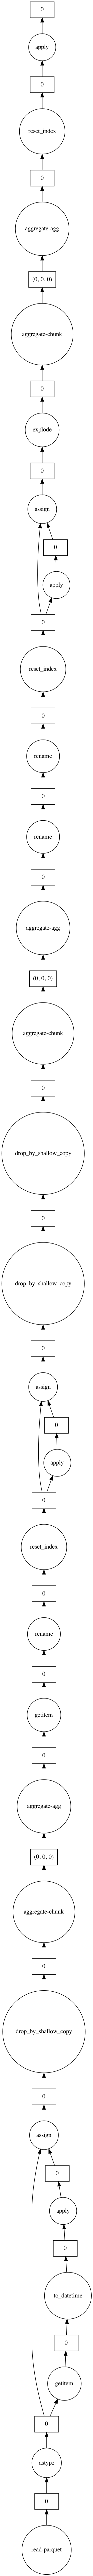

In [191]:
%%time
# Get all main tile coordinates in a list for available zoom levels eg. [(0,0,0), (1,0,0), (2, 0, 0), ... , (5, 0, 0)] for subtile (10,0,0)
df['tile'] = df.apply(lambda x: ancestor_tiles(tileCoord(x.subtile)), axis=1, meta=(None, 'object'))
# Explode and run groupby aggregation by each tile
df = df.explode('tile') \
    .groupby(['feature', 'yearmonth', 'tile']).agg(list) \
    .reset_index() \
    .apply(lambda x: toProto(x), axis=1, meta=(None, 'object')) # convert each row to protobuf
df.visualize()

In [192]:
%%time
df.compute()

CPU times: user 2.73 s, sys: 388 ms, total: 3.11 s
Wall time: 56.9 s


0       {'feature': 'harvest', 'timestamp': '1970-1', ...
1       {'feature': 'harvest', 'timestamp': '1970-1', ...
2       {'feature': 'harvest', 'timestamp': '1970-1', ...
3       {'feature': 'harvest', 'timestamp': '1970-1', ...
4       {'feature': 'harvest', 'timestamp': '1970-1', ...
                              ...                        
1954    {'feature': 'irrigation water', 'timestamp': '...
1955    {'feature': 'irrigation water', 'timestamp': '...
1956    {'feature': 'irrigation water', 'timestamp': '...
1957    {'feature': 'irrigation water', 'timestamp': '...
1958    {'feature': 'irrigation water', 'timestamp': '...
Length: 1959, dtype: object